In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import scipy.io
from w1_reg_utils import sigmoid, relu, plot_decision_boundary, initialize_parameters, load_2D_dataset, predict_dec
from w1_reg_utils import compute_cost, predict, forward_propagation, backward_propagation, update_parameters


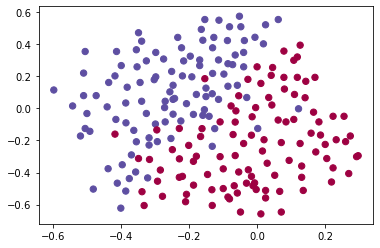

In [5]:
train_X, train_Y, test_X, test_Y = load_2D_dataset()

def model(X, Y, learning_rate = 0.3, num_iterations = 30000, print_cost = True, lambd = 0, keep_prob = 1):
    """
    Implements a three-layer neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (output size, number of examples)
    learning_rate -- learning rate of the optimization
    num_iterations -- number of iterations of the optimization loop
    print_cost -- If True, print the cost every 10000 iterations
    lambd -- regularization hyperparameter, scalar
    keep_prob - probability of keeping a neuron active during drop-out, scalar.
    
    Returns:
    parameters -- parameters learned by the model. They can then be used to predict.
    """
        
    grads = {}
    costs = []                            # to keep track of the cost
    m = X.shape[1]                        # number of examples
    layers_dims = [X.shape[0], 20, 3, 1]
    
    # Initialize parameters dictionary.
    parameters = initialize_parameters(layers_dims)

    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID.
        if keep_prob == 1:
            a3, cache = forward_propagation(X, parameters)
        elif keep_prob < 1:
            a3, cache = forward_propagation_with_dropout(X, parameters, keep_prob)
        
        # Cost function
        if lambd == 0:
            cost = compute_cost(a3, Y)
        else:
            cost = compute_cost_with_regularization(a3, Y, parameters, lambd)
            
        # Backward propagation.
        assert (lambd == 0 or keep_prob == 1)   # it is possible to use both L2 regularization and dropout, 
                                                # but this assignment will only explore one at a time
        if lambd == 0 and keep_prob == 1:
            grads = backward_propagation(X, Y, cache)
        elif lambd != 0:
            grads = backward_propagation_with_regularization(X, Y, cache, lambd)
        elif keep_prob < 1:
            grads = backward_propagation_with_dropout(X, Y, cache, keep_prob)
        
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # Print the loss every 10000 iterations
        if print_cost and i % 10000 == 0:
            print("Cost after iteration {}: {}".format(i, cost))
        if print_cost and i % 1000 == 0:
            costs.append(cost)
    
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (x1,000)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

def compute_cost_with_regularization(A3, Y, parameters, lambd):
    
    m = Y.shape[1]
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    W3 = parameters["W3"]
    
    cross_entropy_cost = compute_cost(A3, Y)
    
    L2_regularization_cost = 1/m*lambd/2*(np.sum(np.square(W1))+np.sum(np.square(W2))+np.sum(np.square(W3)))
    
    cost = cross_entropy_cost + L2_regularization_cost
    
    return cost

def backward_propagation_with_regularization(X, Y, cache, lambd):
    """
    Implements the backward propagation of our baseline model to which we added an L2 regularization.
    
    Arguments:
    X -- input dataset, of shape (input size, number of examples)
    Y -- "true" labels vector, of shape (output size, number of examples)
    cache -- cache output from forward_propagation()
    lambd -- regularization hyperparameter, scalar
    
    Returns:
    gradients -- A dictionary with the gradients with respect to each parameter, activation and pre-activation variables
    """
    
    m = X.shape[1]
    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    
    dW3 = 1./m * np.dot(dZ3, A2.T) +lambd/m*W3
    
    db3 = 1. / m * np.sum(dZ3, axis=1, keepdims=True)
    
    dA2 = np.dot(W3.T, dZ3)
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    
    dW2 = 1./m * np.dot(dZ2, A1.T) +1/m*lambd*W2
    
    db2 = 1. / m * np.sum(dZ2, axis=1, keepdims=True)
    
    dA1 = np.dot(W2.T, dZ2)
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    
    dW1 = 1./m * np.dot(dZ1, X.T) +1/m*lambd*W1
    
    db1 = 1. / m * np.sum(dZ1, axis=1, keepdims=True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,"dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

# GRADED FUNCTION: forward_propagation_with_dropout

def forward_propagation_with_dropout(X, parameters, keep_prob = 0.5):
    
    np.random.seed(1)
    
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    
    Z1 = np.dot(W1, X) + b1
    A1 = relu(Z1)
    
    D1 = np.random.rand(A1.shape[0],A1.shape[1])
    D1 = (D1<keep_prob).astype(int)
    A1 = A1 * D1
    A1 = A1 / keep_prob
    
    Z2 = np.dot(W2, A1) + b2
    A2 = relu(Z2)
    
    D2 = np.random.rand(A2.shape[0],A2.shape[1])
    D2 = (D2<keep_prob).astype(int)
    A2 = A2 * D2
    A2 = A2 / keep_prob
    
    Z3 = np.dot(W3, A2) + b3
    A3 = sigmoid(Z3)
    
    cache = (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3)
    
    return A3, cache
# GRADED FUNCTION: backward_propagation_with_dropout

def backward_propagation_with_dropout(X, Y, cache, keep_prob):
    
    m = X.shape[1]
    (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    dW3 = 1./m * np.dot(dZ3, A2.T)
    db3 = 1./m * np.sum(dZ3, axis=1, keepdims=True)
    dA2 = np.dot(W3.T, dZ3)
    
    dA2 = dA2 * D2
    dA2 = dA2 / keep_prob
    
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = 1./m * np.dot(dZ2, A1.T)
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims=True)
    
    dA1 = np.dot(W2.T, dZ2)
    
    dA1 = dA1 * D1
    dA1 = dA1 / keep_prob
    
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1./m * np.dot(dZ1, X.T)
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims=True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,"dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients